In [1]:
import itertools
import datetime
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import pickle as pkl
import os
import networkx as nx
import torch as th
import torch.nn.functional as F
import dgl
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import sys
sys.path.append(os.path.join(os.getcwd(), 'GasNetwork'))
from TemporalGraphConvolution_AutoEncoder import TGCNAE


Populating the interactive namespace from numpy and matplotlib


## Prepare Data

In [2]:
data = pkl.load(open(os.path.join(os.getcwd(), 'simulated_data.pkl'), "rb"))
maincols = ['pressure_abnormal', 'anomly_flag']
combined_df = pd.concat([data[k][maincols].rename(columns={c: k+'_'+c for c in maincols}) for k in data.keys()], axis=1)
display(combined_df.head())

,reg_0_pressure_abnormal,reg_0_anomly_flag,reg_1_pressure_abnormal,reg_1_anomly_flag,reg_2_pressure_abnormal,reg_2_anomly_flag,syph_0_pressure_abnormal,syph_0_anomly_flag,syph_1_pressure_abnormal,syph_1_anomly_flag,syph_2_pressure_abnormal,syph_2_anomly_flag,syph_3_pressure_abnormal,syph_3_anomly_flag,syph_4_pressure_abnormal,syph_4_anomly_flag
ts,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2.261869,1,2.057695,0,2.075647,0,2.019792,0,2.001544,0,2.068204,0,2.078322,0,2.018328,0
2019-01-01 00:10:00,1.979890,0,2.010181,0,2.000060,0,1.973085,0,1.973797,0,1.998821,0,1.982877,0,2.043523,0
2019-01-01 00:20:00,1.987190,0,1.986864,0,1.965870,0,1.990496,0,1.989531,0,1.967652,0,1.999406,0,1.990907,0
2019-01-01 00:30:00,2.032469,0,2.008972,0,2.009506,0,1.997831,0,2.027557,0,2.042744,0,1.983688,0,1.984104,0
2019-01-01 00:40:00,1.961812,0,2.019287,0,1.956336,0,1.994417,0,2.001734,0,1.985797,0,1.948864,0,2.016498,0


In [3]:
pressure_cols = [c for c in list(combined_df) if 'pressure_abnormal' in c]
pressure_mean = np.nanmean(combined_df[pressure_cols])
pressure_std = np.nanstd(combined_df[pressure_cols])
print(pressure_mean, pressure_std)

1.9887445489219349 0.2189266767950278


In [4]:
combined_df['weekday_value'] = combined_df.index.weekday / 6
combined_df['time_value'] = (combined_df.index.hour*60+combined_df.index.minute) / (23*60+59)
combined_df[pressure_cols] = (combined_df[pressure_cols] - pressure_mean) / pressure_std + 0.5  # shift mean to 0.5

print(np.nanmean(combined_df[pressure_cols]), np.nanstd(combined_df[pressure_cols]))
display(combined_df.head())


0.5000000000000007 1.0


,reg_0_pressure_abnormal,reg_0_anomly_flag,reg_1_pressure_abnormal,reg_1_anomly_flag,reg_2_pressure_abnormal,reg_2_anomly_flag,syph_0_pressure_abnormal,syph_0_anomly_flag,syph_1_pressure_abnormal,syph_1_anomly_flag,syph_2_pressure_abnormal,syph_2_anomly_flag,syph_3_pressure_abnormal,syph_3_anomly_flag,syph_4_pressure_abnormal,syph_4_anomly_flag,weekday_value,time_value
ts,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1.747560,1,0.814948,0,0.896949,0,0.641818,0,0.558464,0,0.862950,0,0.909164,0,0.635127,0,0.166667,0.000000
2019-01-01 00:10:00,0.459553,0,0.597916,0,0.551687,0,0.428470,0,0.431724,0,0.546026,0,0.473197,0,0.750212,0,0.166667,0.006949
2019-01-01 00:20:00,0.492899,0,0.491409,0,0.395516,0,0.507999,0,0.503592,0,0.403653,0,0.548698,0,0.509880,0,0.166667,0.013899
2019-01-01 00:30:00,0.699724,0,0.592392,0,0.594835,0,0.541504,0,0.677283,0,0.746657,0,0.476901,0,0.478803,0,0.166667,0.020848
2019-01-01 00:40:00,0.376980,0,0.639512,0,0.351965,0,0.525909,0,0.559331,0,0.486535,0,0.317837,0,0.626770,0,0.166667,0.027797


In [5]:
pressure_cols = [c for c in list(combined_df) if 'pressure' in c]
time_cols = ['weekday_value', 'time_value']
label_cols = [c for c in list(combined_df) if 'flag' in c]
n_nodes = len(pressure_cols)

## Build Graph

In [6]:
def create_edges_fully_connected(n_nodes):
    edges = list(itertools.permutations(np.arange(n_nodes), 2))  # permutation makes the edges bi-directional
    src, dst = tuple(zip(*edges))
    return src, dst

gasnetwork_graph = dgl.DGLGraph()
gasnetwork_graph.add_nodes(n_nodes)  # each sensor is a node, node label is from 0
src, dst = create_edges_fully_connected(n_nodes)  # build a fully connected graph, because gas network is assumed to be spider net like
gasnetwork_graph.add_edges(src, dst)
print('number of nodes = {}'.format(gasnetwork_graph.number_of_nodes()))
print('number of edges = {}'.format(gasnetwork_graph.number_of_edges()))
gasnetwork_graph.set_n_initializer(dgl.init.zero_initializer)  # Set the initializer for empty node features. (Set to 0)
gasnetwork_graph.set_e_initializer(dgl.init.zero_initializer)  # Set the initializer for empty edge features. (Set to 0)


number of nodes = 8
number of edges = 56


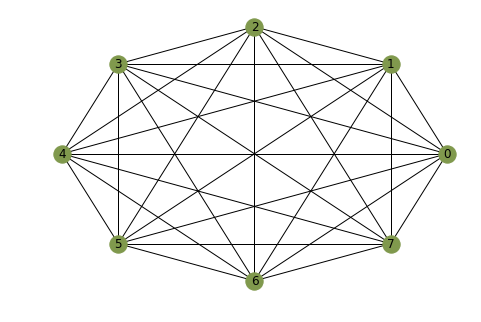

In [7]:
# visualize the graph
gnw_g = gasnetwork_graph.to_networkx().to_undirected()
gnw_pos = nx.kamada_kawai_layout(gnw_g)  # Kamada-Kawaii layout
nx.draw(gnw_g, gnw_pos, with_labels=True, node_color=[[0.5, 0.6, 0.3]])
plt.show()

## Assign Data

In [8]:
def chopts(df, length, nodes_cols_dict):
    n_nodes = len(nodes_cols_dict)
    new_df = {k: {'val': [], 'cols': nodes_cols_dict[k]} for k in range(len(nodes_cols_dict))}
    for i in range(len(df)-length+1):
        tmp = df.iloc[i:length+i]
        for j in range(n_nodes):
            new_df[j]['val'].append(tmp[nodes_cols_dict[j]].values)
    for k in new_df.keys():
        new_df[k]['val'] = np.stack(new_df[k]['val'])
    return new_df


In [9]:
gap = datetime.timedelta(seconds=60*10)
period = int(datetime.timedelta(days=1) / gap)
nodes_cols_dict = [[c]+time_cols for c in pressure_cols]
new_combined_df = chopts(combined_df, period, nodes_cols_dict)

g_data = [new_combined_df[k]['val'] for k in new_combined_df.keys()]
g_data = np.stack(g_data)
print(g_data.shape)


(8, 1873, 144, 3)


In [10]:
print(g_data.max(), g_data.min(), g_data.mean())
print(gasnetwork_graph)

3.077413040551959 -7.638207289634607 0.5080248288214552
DGLGraph(num_nodes=8, num_edges=56,
         ndata_schemes={}
         edata_schemes={})


## Train Model

In [11]:
in_feats = 3  # 2 time features and 1 pressure features
tgcnout_feats = 1  # output 1 feature from tgcn cell
seq_length = 144
hidden_dim_list = [20, 10]
dropout = 0.1
activf = F.relu
inputs = th.tensor(g_data, dtype=th.float32)

In [12]:
gasnetwork_model = TGCNAE(in_feats, tgcnout_feats, seq_length, hidden_dim_list,
                          tempo_nlayers=2, dropout=0.1, activf=F.relu, bias=True)
optimizer = th.optim.Adam(gasnetwork_model.parameters(), lr=0.01)


In [ ]:
all_preds, all_loss = [], []

for epoch in range(100):
    pred = gasnetwork_model(gasnetwork_graph, inputs)
    all_preds.append(pred.detach())  # .detach is to get the data

    loss = F.mse_loss(pred, inputs[:, :, :, 0].unsqueeze(3))  # .unsqueeze to extend dimension
    all_loss.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))



In [26]:
# save model
th.save(gasnetwork_model, 'gasnetwork_model_(simulated).pth')

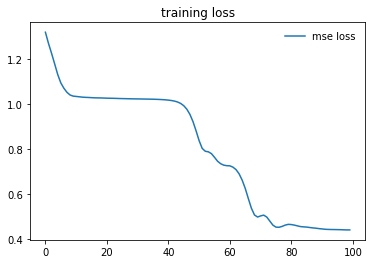

In [14]:
plt.plot(all_loss, label='mse loss')
plt.legend(frameon=False)
plt.title('training loss')
plt.show()

## Result Analysis

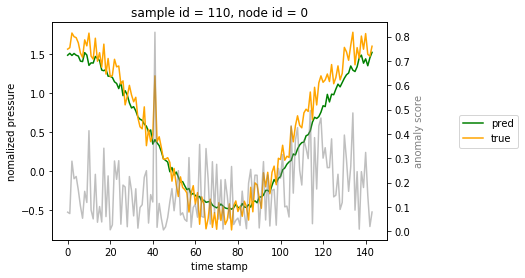

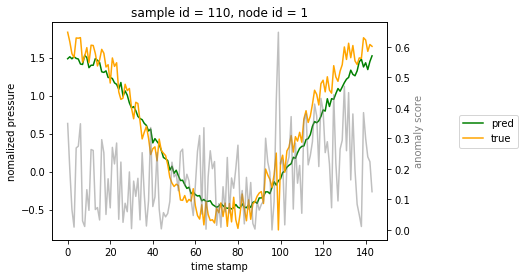

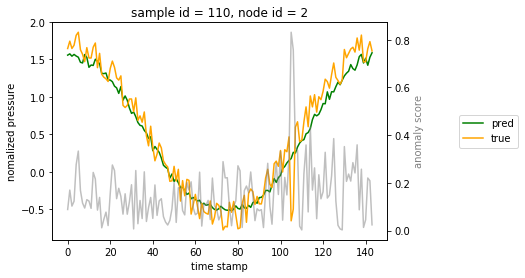

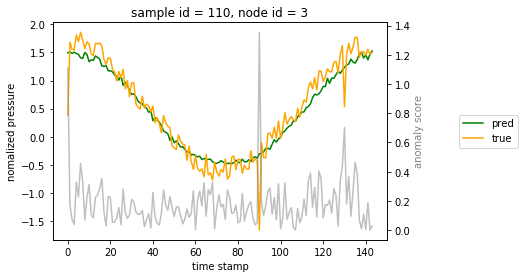

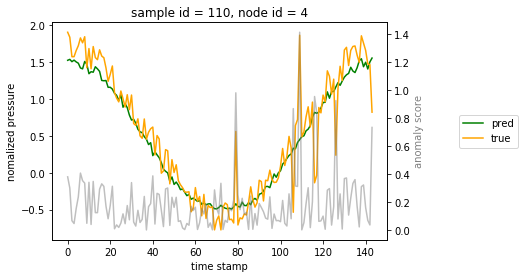

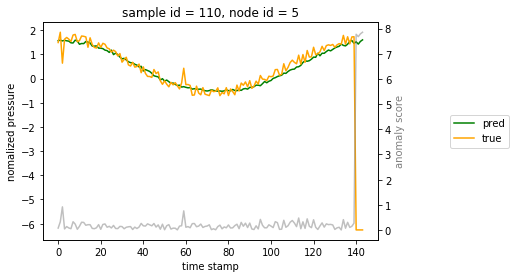

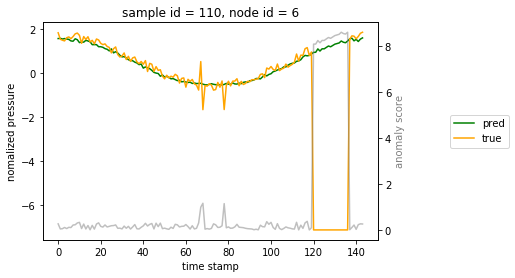

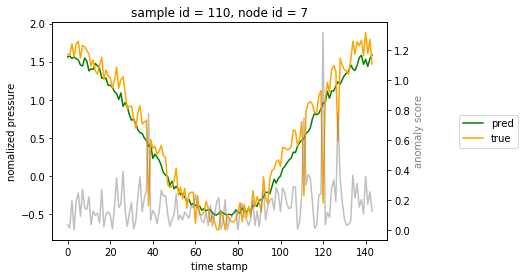

In [24]:
optimum_epoch = 99
sample_id = 110

for node_id in range(8):
    pred_i = th.flatten(all_preds[optimum_epoch][node_id, sample_id, :, :], start_dim=0)
    true_i = th.flatten(inputs[:, :, :, 0].unsqueeze(3)[node_id, sample_id, :, :], start_dim=0)
    anomaly_score_i = abs(pred_i - true_i)

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time stamp')
    ax1.set_ylabel('nomalized pressure', color='black')
    ax1.plot(np.asarray(pred_i), label='pred', color='green')
    ax1.plot(np.asarray(true_i), label='true', color='orange')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('anomaly score', color='grey')
    ax2.plot(np.asarray(anomaly_score_i), alpha=0.5, color='grey')
    
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    plt.title('sample id = {}, node id = {}'.format(sample_id, node_id))
    plt.show()


## Test the saved model

In [36]:
model = th.load('gasnetwork_model_(simulated).pth')
model.eval()

TGCNAE(
  (tgcn_layer): TGCNLayer(
    (temporal_cell): LSTM(3, 1, num_layers=2, batch_first=True, dropout=0.1)
  )
  (encoder): Sequential(
    (0): Linear(in_features=144, out_features=20, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=20, out_features=144, bias=True)
    (3): ELU(alpha=1.0)
  )
)

In [39]:
pred = model(gasnetwork_graph, inputs)
print(pred.shape)

torch.Size([8, 1873, 144, 1])


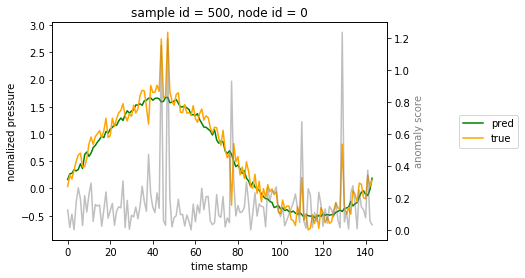

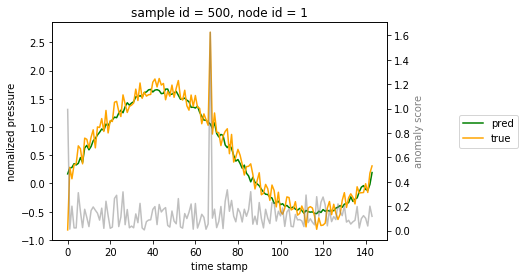

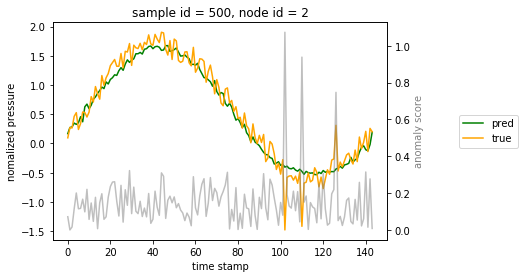

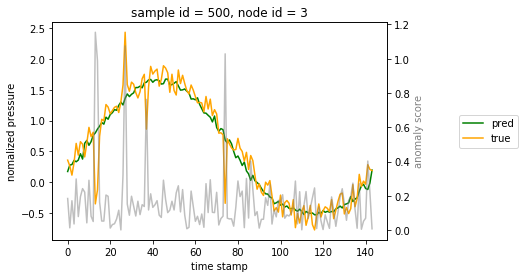

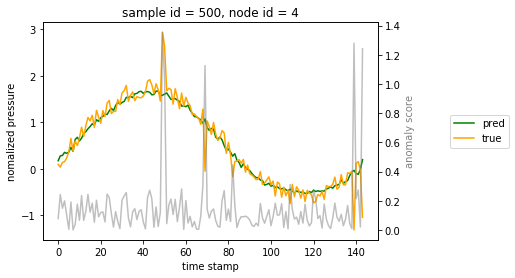

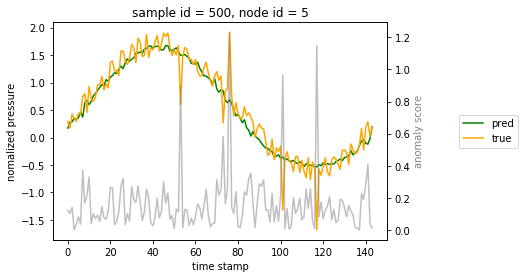

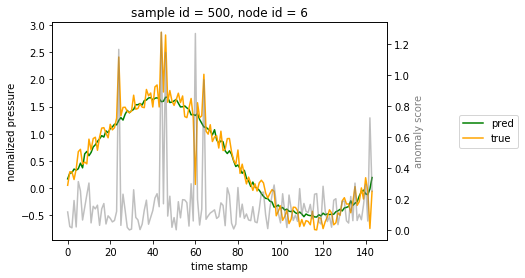

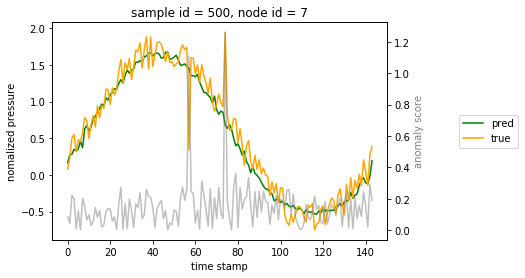

In [49]:
sample_id = 500

for node_id in range(8):
    pred_i = th.flatten(pred[node_id, sample_id, :, :], start_dim=0).detach()
    true_i = th.flatten(inputs[:, :, :, 0].unsqueeze(3)[node_id, sample_id, :, :], start_dim=0)
    anomaly_score_i = abs(pred_i - true_i)

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time stamp')
    ax1.set_ylabel('nomalized pressure', color='black')
    ax1.plot(np.asarray(pred_i), label='pred', color='green')
    ax1.plot(np.asarray(true_i), label='true', color='orange')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('anomaly score', color='grey')
    ax2.plot(np.asarray(anomaly_score_i), alpha=0.5, color='grey')
    
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    plt.title('sample id = {}, node id = {}'.format(sample_id, node_id))
    plt.show()